<a href="https://colab.research.google.com/github/pbcpraveen/IDD-Challenge/blob/master/FCN_train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!unzip idd-lite.zip
!unzip idd-lite_1.zip

Archive:  idd-lite.zip
   creating: idd-lite/
   creating: idd-lite/idd20k_lite/
   creating: idd-lite/idd20k_lite/gtFine/
   creating: idd-lite/idd20k_lite/gtFine/val/
   creating: idd-lite/idd20k_lite/gtFine/val/234/
  inflating: idd-lite/idd20k_lite/gtFine/val/234/frame2014_inst_label.png  
  inflating: idd-lite/idd20k_lite/gtFine/val/234/frame2014_label.png  
  inflating: idd-lite/idd20k_lite/gtFine/val/234/frame3334_label.png  
  inflating: idd-lite/idd20k_lite/gtFine/val/234/frame3334_inst_label.png  
   creating: idd-lite/idd20k_lite/gtFine/val/420/
  inflating: idd-lite/idd20k_lite/gtFine/val/420/0016811_inst_label.png  
  inflating: idd-lite/idd20k_lite/gtFine/val/420/0032658_label.png  
  inflating: idd-lite/idd20k_lite/gtFine/val/420/0022565_label.png  
  inflating: idd-lite/idd20k_lite/gtFine/val/420/0036971_label.png  
  inflating: idd-lite/idd20k_lite/gtFine/val/420/0017446_label.png  
  inflating: idd-lite/idd20k_lite/gtFine/val/420/0022565_inst_label.png  
  inflating: 

In [0]:
import cv2, os, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import keras, sys, time, warnings
from keras.models import *
from keras.layers import *
from keras import optimizers

In [0]:
data = 'idd-lite_1/idd20k_lite/'

img_train = data + 'leftImg8bit/train/'
seg_train = data + 'gtFine/train/'

img_val = data + 'leftImg8bit/val/'
seg_val = data + 'gtFine/val/'

In [0]:
mi, ma = 0, 6 #np.min(seg), np.max(seg)
n_classes = ma - mi + 1

In [0]:
def getImageArr(path, width, height):
    img = cv2.imread(path, 1)
    img = np.float32(cv2.resize(img, (width, height))) / 127.5 - 1
    return img

def getSegmentationArr(path, nClasses, width, height):
    seg_labels = np.zeros((height, width, nClasses))
    img = cv2.imread(path, 1)
    img = cv2.resize(img, (width, height))
    img = img[:, :, 0]

    for c in range(nClasses):
        seg_labels[:, :, c] = (img == c ).astype(int)

    return seg_labels

In [0]:
input_height, input_width = 224, 224
output_height, output_width = 224, 224

In [0]:
X_train, y_train = [], []
X_val, y_val = [], []

In [0]:
train_img = os.listdir(img_train)
train_img.sort()
train_seg = os.listdir(seg_train)
train_seg.sort()

val_img = os.listdir(img_val)
val_img.sort()
val_seg = os.listdir(seg_val)
val_seg.sort()

In [0]:
print(train_img[: 5])
print(train_seg[: 5])
print(val_img[: 5])
print(val_seg[: 5])

['0000002_image.jpg', '0000097_image.jpg', '0000192_image.jpg', '0000215_image.jpg', '0000247_image.jpg']
['0000002_label.png', '0000097_label.png', '0000192_label.png', '0000215_label.png', '0000247_label.png']
['0000000_image.jpg', '000065_image.jpg', '0001080_image.jpg', '000190_image.jpg', '0001923_image.jpg']
['0000000_label.png', '000065_label.png', '0001080_label.png', '000190_label.png', '0001923_label.png']


In [0]:
for im, seg in zip(train_img, train_seg):
    X_train.append(getImageArr(img_train + im, input_width, input_height))
    y_train.append(getSegmentationArr(seg_train + seg, n_classes, output_width, output_height))
    
for im, seg in zip(val_img, val_seg):
    X_val.append(getImageArr(img_val + im, input_width, input_height))
    y_val.append(getSegmentationArr(seg_val + seg, n_classes, output_width, output_height))

In [0]:
X_train, y_train = np.array(X_train), np.array(y_train)
X_val, y_val = np.array(X_val),np.array(y_val)

In [0]:
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(1380, 224, 224, 3) (1380, 224, 224, 7)
(204, 224, 224, 3) (204, 224, 224, 7)


In [0]:
VGG_Weights_path = 'vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'

In [0]:
def FCN8(nClasses, input_width = 224, input_height = 224):
    assert input_width % 32 == 0
    assert input_height % 32 == 0
    IMAGE_ORDERING = 'channels_last'
    
    img_input = Input(shape = (input_height, input_width, 3))
    
    x = Conv2D(64, (3, 3), activation = 'relu', padding = 'same', name = 'block1_conv1', data_format = IMAGE_ORDERING )(img_input)
    x = Conv2D(64, (3, 3), activation = 'relu', padding = 'same', name = 'block1_conv2', data_format = IMAGE_ORDERING )(x)
    x = MaxPooling2D((2, 2), strides = (2, 2), name = 'block1_pool', data_format = IMAGE_ORDERING )(x)
    f1 = x
    
    x = Conv2D(128, (3, 3), activation = 'relu', padding = 'same', name = 'block2_conv1', data_format = IMAGE_ORDERING )(x)
    x = Conv2D(128, (3, 3), activation = 'relu', padding = 'same', name = 'block2_conv2', data_format = IMAGE_ORDERING )(x)
    x = MaxPooling2D((2, 2), strides = (2, 2), name = 'block2_pool', data_format = IMAGE_ORDERING )(x)
    f2 = x
    
    x = Conv2D(256, (3, 3), activation = 'relu', padding = 'same', name = 'block3_conv1', data_format = IMAGE_ORDERING )(x)
    x = Conv2D(256, (3, 3), activation = 'relu', padding = 'same', name = 'block3_conv2', data_format = IMAGE_ORDERING )(x)
    x = Conv2D(256, (3, 3), activation = 'relu', padding = 'same', name = 'block3_conv3', data_format = IMAGE_ORDERING )(x)
    x = MaxPooling2D((2, 2), strides = (2, 2), name = 'block3_pool', data_format = IMAGE_ORDERING )(x)
    pool3 = x
    
    x = Conv2D(512, (3, 3), activation = 'relu', padding = 'same', name = 'block4_conv1', data_format = IMAGE_ORDERING )(x)
    x = Conv2D(512, (3, 3), activation = 'relu', padding = 'same', name = 'block4_conv2', data_format = IMAGE_ORDERING )(x)
    x = Conv2D(512, (3, 3), activation = 'relu', padding = 'same', name = 'block4_conv3', data_format = IMAGE_ORDERING )(x)
    x = MaxPooling2D((2, 2), strides = (2, 2), name = 'block4_pool', data_format = IMAGE_ORDERING )(x)
    pool4 = x
    
    x = Conv2D(512, (3, 3), activation = 'relu', padding = 'same', name = 'block5_conv1', data_format = IMAGE_ORDERING )(pool4)
    x = Conv2D(512, (3, 3), activation = 'relu', padding = 'same', name = 'block5_conv2', data_format = IMAGE_ORDERING )(x)
    x = Conv2D(512, (3, 3), activation = 'relu', padding = 'same', name = 'block5_conv3', data_format = IMAGE_ORDERING )(x)
    x = MaxPooling2D((2, 2), strides = (2, 2), name = 'block5_pool', data_format = IMAGE_ORDERING )(x)
    pool5 = x
    
    vgg = Model(img_input, pool5)
    vgg.load_weights(VGG_Weights_path)
    
    n = 4096
    o = (Conv2D(n, (7, 7), activation = 'relu', padding = 'same', name = 'conv6', data_format = IMAGE_ORDERING))(pool5)
    conv7 = (Conv2D(n, (1, 1), activation = 'relu', padding = 'same', name = 'conv7', data_format = IMAGE_ORDERING))(o)
    
    conv7_4 = Conv2DTranspose(nClasses, kernel_size = (4, 4) ,strides = (4, 4), use_bias = False, data_format = IMAGE_ORDERING )(conv7)
    
    pool411 = (Conv2D(nClasses, (1, 1), activation = 'relu', padding = 'same', name = 'pool4_11', data_format = IMAGE_ORDERING))(pool4)
    pool411_2 = (Conv2DTranspose(nClasses, kernel_size = (2, 2), strides = (2, 2), use_bias = False, data_format = IMAGE_ORDERING ))(pool411)
    
    pool311 = (Conv2D(nClasses, (1, 1), activation = 'relu', padding = 'same', name = 'pool3_11', data_format = IMAGE_ORDERING))(pool3)
        
    o = Add(name = 'add')([pool411_2, pool311, conv7_4])
    o = Conv2DTranspose(nClasses, kernel_size = (8, 8), strides = (8, 8), use_bias = False, data_format = IMAGE_ORDERING )(o)
    o = (Activation('softmax'))(o)
    
    model = Model(img_input, o)

    return model

In [0]:
model = FCN8(nClasses = n_classes, input_width  = 224, input_height = 224)
model.summary()

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 224, 224, 64) 1792        input_4[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 224, 224, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 112, 112, 64) 0           block1_conv2[0][0]               
____________________________________________________________________________________________

In [0]:
sgd = optimizers.SGD(lr = 0.01, decay = 5 ** (-4), momentum = 0.9, nesterov = True)
model.compile(loss = 'categorical_crossentropy',
              optimizer = sgd,
              metrics = ['accuracy'])

In [0]:
hist1 = model.fit(X_train, y_train,
                  validation_data = (X_val, y_val),
                  batch_size = 32, epochs = 200, verbose = 1)

Train on 1380 samples, validate on 204 samples
Epoch 1/200
1380/1380 [==============================] - 31s 23ms/step - loss: 1.9619 - acc: 0.1501 - val_loss: 1.9417 - val_acc: 0.1535
Epoch 2/200
1380/1380 [==============================] - 26s 19ms/step - loss: 1.9340 - acc: 0.1644 - val_loss: 1.9197 - val_acc: 0.1768
Epoch 3/200
1380/1380 [==============================] - 26s 19ms/step - loss: 1.8480 - acc: 0.2389 - val_loss: 1.6632 - val_acc: 0.3546
Epoch 4/200
1380/1380 [==============================] - 26s 19ms/step - loss: 1.1880 - acc: 0.5751 - val_loss: 1.1458 - val_acc: 0.6277
Epoch 5/200
1380/1380 [==============================] - 26s 19ms/step - loss: 0.8905 - acc: 0.7082 - val_loss: 0.8732 - val_acc: 0.6975
Epoch 6/200
1380/1380 [==============================] - 26s 19ms/step - loss: 0.7476 - acc: 0.7299 - val_loss: 0.7980 - val_acc: 0.7142
Epoch 7/200
1380/1380 [==============================] - 26s 19ms/step - loss: 0.6977 - acc: 0.7430 - val_loss: 0.7074 - val_acc: 0

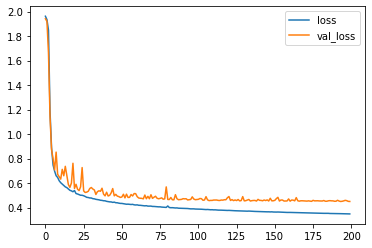

In [0]:
for key in ['loss', 'val_loss']:
    plt.plot(hist1.history[key], label = key)
plt.legend()
plt.show()

In [0]:
y_pred = model.predict(X_val)
y_predi = np.argmax(y_pred, axis=3)
y_testi = np.argmax(y_val, axis=3)
print(y_testi.shape,y_predi.shape)

(204, 224, 224) (204, 224, 224)


In [0]:
def IoU(yi, y_predi):
    ## mean Intersection over Union
    ## Mean IoU = TP/(FN + TP + FP)
    IoUs = []
    Nclass = 7 #int(np.max(yi)) + 1. This might be an error. Please check
    for c in range(Nclass):
        TP = np.sum((yi == c) & (y_predi == c))
        FP = np.sum((yi != c) & (y_predi == c))
        FN = np.sum((yi == c) & (y_predi != c)) 
        IoU = TP/float(TP + FP + FN)
        print('class {:02.0f}: #TP={:6.0f}, #FP={:6.0f}, #FN={:5.0f}, IoU={:4.3f}'.format(c, TP, FP, FN, IoU))
        IoUs.append(IoU)
    mIoU = np.mean(IoUs)
    print('Mean IoU: {:4.3f}'.format(mIoU))

In [0]:
IoU(y_testi,y_predi)

class 00: #TP=3098921, #FP=237970, #FN=125801, IoU=0.895
class 01: #TP= 72785, #FP= 76966, #FN=195306, IoU=0.211
class 02: #TP= 39790, #FP= 37094, #FN=153988, IoU=0.172
class 03: #TP=670818, #FP=241909, #FN=206790, IoU=0.599
class 04: #TP=657393, #FP=550637, #FN=569436, IoU=0.370
class 05: #TP=2001031, #FP=502052, #FN=415233, IoU=0.686
class 06: #TP=1930465, #FP=118073, #FN=98147, IoU=0.899
Mean IoU: 0.547


In [0]:
model.save('fcn.h5')

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
model.save('/content/gdrive/My Drive/IDD Challenge/fcn.h5')